In [1]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Zilany/Twitter- datasets.csv")

In [3]:
df.head()

,id,user_posted,name,description,date_posted,photos,url,tagged_users,replies,reposts,...,posts_count,profile_image_link,following,is_verified,quotes,bookmarks,parent_post_details,external_image_urls,videos,quoted_post
0,1868428607451799983,Glo███ews███,Glo███ews███,"Com o fim da ditadura Assad, muitos sírios con...","""2024-12-15T22:51:08.000Z""",NaN,https://x.com/GloboNews/status/186842860745179...,NaN,2,1,...,222223,https://pbs.twimg.com/profile_images/155910271...,122,False,1,1,"{""post_id"":null,""profile_id"":null,""profile_nam...",NaN,"[{""duration"":148167,""video_url"":""https://video...","{""data_posted"":null,""description"":null,""photos..."
1,1868159094567121215,bil███ard███,bil███ard███,Brian Austin Green Tells MGK to ‘Grow Up’ Afte...,"""2024-12-15T05:00:11.000Z""",NaN,https://x.com/billboard/status/186815909456712...,NaN,7,3,...,357584,https://pbs.twimg.com/profile_images/169657720...,3784,False,1,2,"{""post_id"":null,""profile_id"":null,""profile_nam...","[""https://pbs.twimg.com/card_img/1867636129563...",NaN,"{""data_posted"":null,""description"":null,""photos..."
2,1868451534708883739,TNT███rts███,TNT███ort███R,VENCE O PSG NO CLÁSSICO! 💪🇫🇷 Nossa @claalbuque...,"""2024-12-16T00:22:14.000Z""",NaN,https://x.com/TNTSportsBR/status/1868451534708...,"[{""biography"":null,""followers"":null,""following...",2,1,...,456734,https://pbs.twimg.com/profile_images/180701304...,859,False,0,1,"{""post_id"":null,""profile_id"":null,""profile_nam...",NaN,"[{""duration"":94861,""video_url"":""https://video....","{""data_posted"":null,""description"":null,""photos..."
3,1868441382022717466,TNT███rts███,TNT███ort███R,ÍDOLO E AGORA PRESIDENTE! 🇦🇷🇦🇷 O ex-atacante D...,"""2024-12-15T23:41:54.000Z""","[""https://pbs.twimg.com/media/Ge4JhOgXcAAQy5K....",https://x.com/TNTSportsBR/status/1868441382022...,"[{""biography"":null,""followers"":null,""following...",6,5,...,456734,https://pbs.twimg.com/profile_images/180701304...,859,False,1,3,"{""post_id"":null,""profile_id"":null,""profile_nam...",NaN,NaN,"{""data_posted"":null,""description"":null,""photos..."
4,1868418260892565925,Glo███ews███,Glo███ews███,.@DanielaLima_ : cirurgia de Lula travou negoc...,"""2024-12-15T22:10:01.000Z""",NaN,https://x.com/GloboNews/status/186841826089256...,"[{""biography"":null,""followers"":null,""following...",50,4,...,222223,https://pbs.twimg.com/profile_images/155910271...,122,False,3,3,"{""post_id"":null,""profile_id"":null,""profile_nam...",NaN,"[{""duration"":127067,""video_url"":""https://video...","{""data_posted"":null,""description"":null,""photos..."


In [4]:
def inspect_dataframe(df):
    print("----- DATAFRAME INFO -----")
    print(df.info(), "\n")

    print("----- DATAFRAME SHAPE -----")
    print(df.shape, "\n")

    print("----- COLUMN NAMES -----")
    print(df.columns, "\n")

    print("----- STATISTICS -----")
    print(df.describe(), "\n")

    print("----- MISSING VALUES PER COLUMN -----")
    print(df.isnull().sum(), "\n")

    print("----- TOTAL MISSING VALUES -----")
    print(df.isnull().sum().sum(), "\n")

    print("----- DATA TYPES -----")
    print(df.dtypes, "\n")

    print("----- UNIQUE VALUES PER COLUMN -----")
    print(df.nunique(), "\n")


In [5]:
inspect_dataframe(df)

----- DATAFRAME INFO -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   1000 non-null   int64 
 1   user_posted          1000 non-null   object
 2   name                 1000 non-null   object
 3   description          1000 non-null   object
 4   date_posted          1000 non-null   object
 5   photos               456 non-null    object
 6   url                  1000 non-null   object
 7   tagged_users         374 non-null    object
 8   replies              1000 non-null   int64 
 9   reposts              1000 non-null   int64 
 10  likes                1000 non-null   int64 
 11  views                1000 non-null   int64 
 12  external_url         432 non-null    object
 13  hashtags             572 non-null    object
 14  followers            1000 non-null   int64 
 15  biography            997 non-

In [6]:
df['photos'] = df['photos'].apply(lambda x: 'No' if pd.isna(x) else 'Yes')
print(df.value_counts('photos'))

photos
No     544
Yes    456
Name: count, dtype: int64


In [7]:
df['photos'] = df['photos'].map({'Yes':1, 'No':0})

In [8]:
# date & time
def extract_hour_month(df, date_column):
    # clean the datetime strings
    clean_date = (
        df[date_column]
        .astype(str)
        .str.strip()
        .str.replace('^"|"$', '', regex=True)
    )

    dt = pd.to_datetime(
        clean_date,
        format='%Y-%m-%dT%H:%M:%S.%fZ',
        utc=True,
        errors='coerce'
    )

    # hour and month
    df[f'{date_column}_hour'] = dt.dt.hour.fillna(-1).astype(int)
    df[f'{date_column}_month'] = dt.dt.month.fillna(-1).astype(int)

    return df

df = extract_hour_month(df, 'date_posted')

In [9]:
# replace nulls with empty list
df['hashtags'] = df['hashtags'].apply(lambda x: [] if pd.isna(x) else x)

df['hashtag_Y/N'] = df['hashtags'].apply(lambda x: 1 if len(x) > 0 else 0)


In [10]:
columns_to_drop = ['id', 'user_posted', 'name', 'url', 'tagged_users', 'external_url', 'biography', 'profile_image_link', 'is_verified', 'quotes',
                      'posts_count', 'parent_post_details', 'external_image_urls', 'videos', 'quoted_post', 'date_posted', 'hashtags']

df = df.drop(columns=columns_to_drop)

In [11]:
inspect_dataframe(df)

----- DATAFRAME INFO -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        1000 non-null   object
 1   photos             1000 non-null   int64 
 2   replies            1000 non-null   int64 
 3   reposts            1000 non-null   int64 
 4   likes              1000 non-null   int64 
 5   views              1000 non-null   int64 
 6   followers          1000 non-null   int64 
 7   following          1000 non-null   int64 
 8   bookmarks          1000 non-null   int64 
 9   date_posted_hour   1000 non-null   int64 
 10  date_posted_month  1000 non-null   int64 
 11  hashtag_Y/N        1000 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 93.9+ KB
None 

----- DATAFRAME SHAPE -----
(1000, 12) 

----- COLUMN NAMES -----
Index(['description', 'photos', 'replies', 'reposts', 'likes', 'views',
       'foll

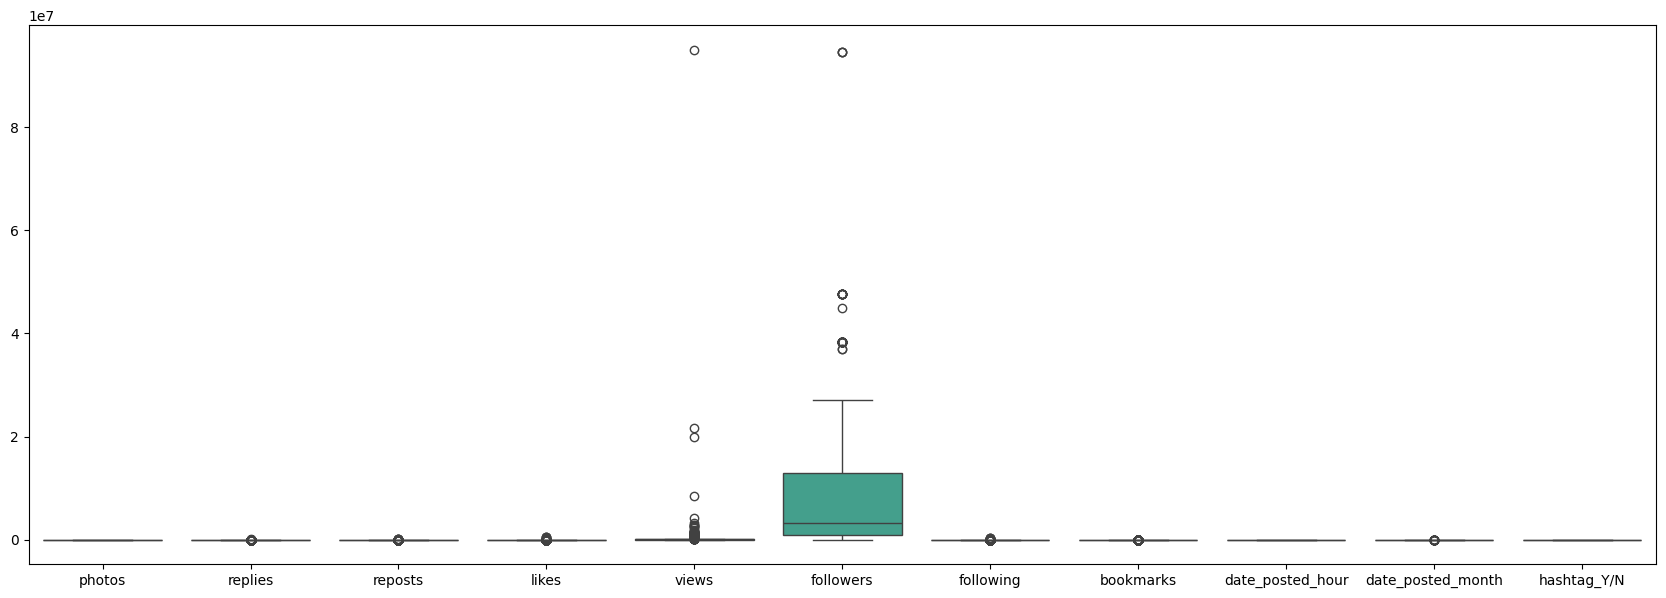

In [12]:
plt.figure(figsize=(21, 7))
sns.boxplot(data = df, orient='v')
plt.show()

In [13]:
def detect_outliers_iqr(df, drop_cols=None):
    if drop_cols is not None:
        df = df.drop(columns=drop_cols, errors='ignore')

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    outlier_summary = []

    for col in numeric_cols:
        series = df[col].dropna()
        if series.nunique() < 2:
            continue
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1

        if iqr == 0:
            continue

        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        outliers = series[(series < lower) | (series > upper)]

        outlier_summary.append({
            'feature': col,
            'outlier_count': len(outliers),
            'outlier_percentage': round(len(outliers) / len(series) * 100, 2),
        })

    return pd.DataFrame(outlier_summary)

In [14]:
outliers = detect_outliers_iqr(
    df,
    drop_cols=['id', 'date_posted_hour', 'date_posted_month']
)

outliers.sort_values('outlier_percentage', ascending=False)


,feature,outlier_count,outlier_percentage
6,following,159,15.9
2,reposts,153,15.3
3,likes,143,14.3
7,bookmarks,140,14.0
4,views,132,13.2
1,replies,129,12.9
5,followers,49,4.9
0,photos,0,0.0
8,hashtag_Y/N,0,0.0


In [15]:
df['engagement'] = (df['likes'] + df['reposts'] + df['replies'] + df['bookmarks'])

In [16]:
df['trend_score'] = df['engagement'] * np.log1p(df['followers'])

In [17]:
df['post_length'] = df['description'].astype(str).apply(len)

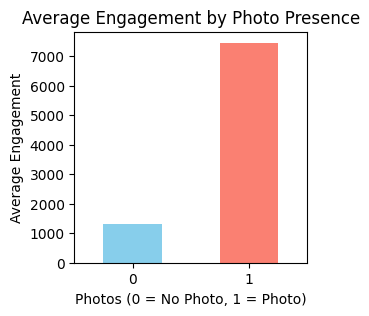

In [18]:
engagement_by_photos = df.groupby('photos')['engagement'].mean()
plt.figure(figsize=(3, 3))
engagement_by_photos.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Photos (0 = No Photo, 1 = Photo)')
plt.ylabel('Average Engagement')
plt.title('Average Engagement by Photo Presence')
plt.xticks(rotation=0)
plt.show()


In [19]:
df.groupby('hashtag_Y/N')['engagement'].mean()


,engagement
hashtag_Y/N,
0,5995.446262
1,2709.223776


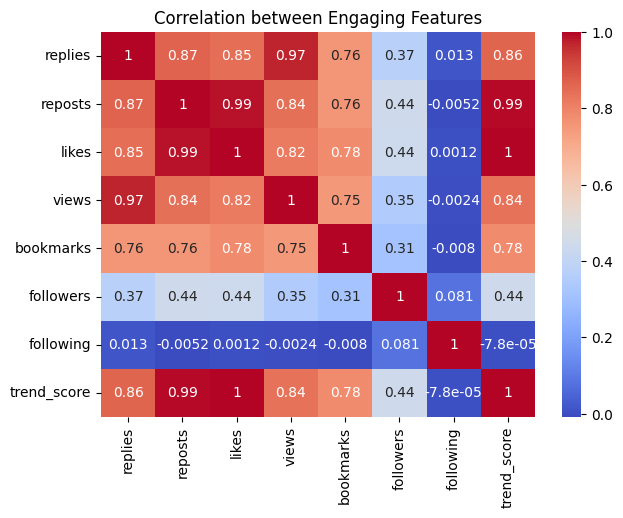

In [20]:
# Correlation heatmap
eng_cols = ['replies','reposts','likes','views','bookmarks','followers','following', 'trend_score']
plt.figure(figsize=(7,5))
sns.heatmap(df[eng_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between Engaging Features")
plt.show()


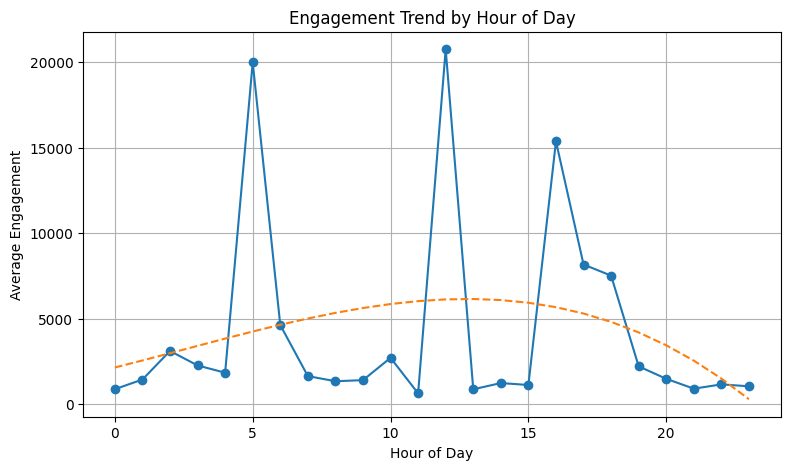

In [21]:
# average engagement per hour
hourly_engagement = df.groupby('date_posted_hour')['engagement'].mean()

plt.figure(figsize=(9, 5))
plt.plot(hourly_engagement.index, hourly_engagement.values, marker='o')
z = np.polyfit(hourly_engagement.index, hourly_engagement.values, 3)
p = np.poly1d(z)
plt.plot(hourly_engagement.index, p(hourly_engagement.index), linestyle='--')
plt.title('Engagement Trend by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Engagement')
plt.grid(True)
plt.show()


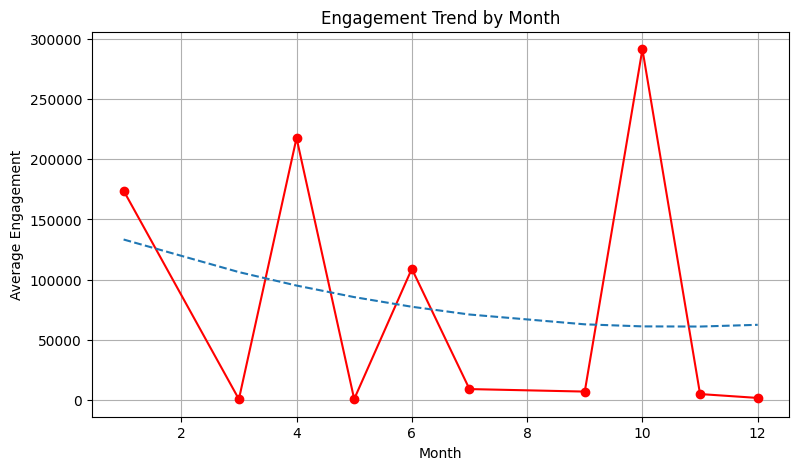

In [22]:
# average engagement per month
monthly_engagement = df.groupby('date_posted_month')['engagement'].mean()

plt.figure(figsize=(9, 5))
plt.plot(monthly_engagement.index, monthly_engagement.values, color='red', marker='o')
z = np.polyfit(monthly_engagement.index, monthly_engagement.values, 2)
p = np.poly1d(z)
plt.plot(monthly_engagement.index, p(monthly_engagement.index), linestyle='--')
plt.title('Engagement Trend by Month')
plt.xlabel('Month')
plt.ylabel('Average Engagement')
plt.grid(True)
plt.show()


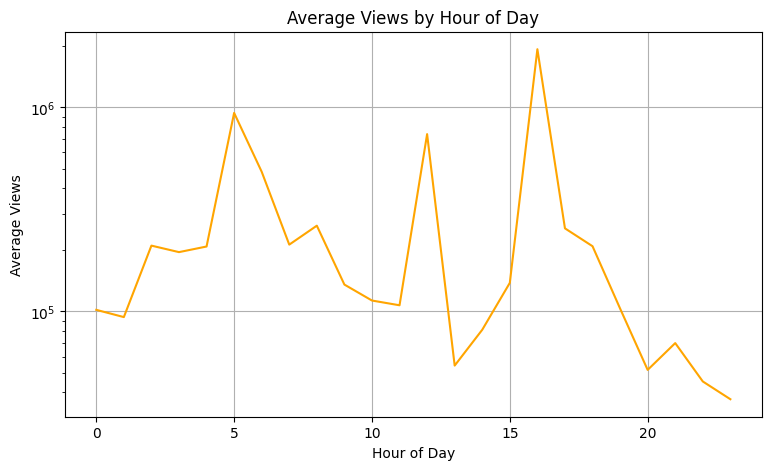

In [23]:
# avarage views per hour
hourly_views = df.groupby('date_posted_hour')['views'].mean()

plt.figure(figsize=(9, 5))
plt.plot(hourly_views.index, hourly_views.values, color='orange')
plt.title('Average Views by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Views')
plt.yscale('log')
plt.grid(True)
plt.show()


In [24]:
df

,description,photos,replies,reposts,likes,views,followers,following,bookmarks,date_posted_hour,date_posted_month,hashtag_Y/N,engagement,trend_score,post_length
0,"Com o fim da ditadura Assad, muitos sírios con...",0,2,1,33,8369,5771758,122,1,22,12,1,37,576.034035,220
1,Brian Austin Green Tells MGK to ‘Grow Up’ Afte...,0,7,3,43,25007,14257909,3784,2,5,12,0,55,906.005232,97
2,VENCE O PSG NO CLÁSSICO! 💪🇫🇷 Nossa @claalbuque...,0,2,1,33,15497,8293189,859,1,0,12,1,37,589.444974,224
3,ÍDOLO E AGORA PRESIDENTE! 🇦🇷🇦🇷 O ex-atacante D...,1,6,5,230,18267,8293189,859,3,23,12,0,244,3887.150642,121
4,.@DanielaLima_ : cirurgia de Lula travou negoc...,0,50,4,84,9569,5771758,122,3,22,12,1,141,2195.156730,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,This shouldn't come as a surprise!\n\n@CubSwan...,1,42,81,1341,156329,12876593,717,16,6,12,1,1480,24228.964268,131
996,HERE. WE. GO. \n\n#SNME starts RIGHT NOW on @n...,0,122,393,2579,279472,14375935,392,39,1,12,1,3133,51635.180579,62
997,Coming to the cricket...\n\nDressed as cricket...,1,15,21,764,84181,551402,282,13,9,12,1,813,10748.039850,54
998,.@MoanaPasifika_ has entered the chat 🫡\n\nWh...,1,4,3,34,4471,305976,302,2,21,12,1,43,543.144404,120


In [25]:
features = ['photos', 'hashtag_Y/N', 'date_posted_hour', 'date_posted_month','followers',
            'following', 'post_length']

In [26]:
X = df[features]
y = df['views']

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=0,
    n_jobs=-1
)

rf.fit(X_train, y_train_log)
y_pred_rf = rf.predict(X_test)

print("Random Forest")
print("R²:", r2_score(y_test_log, y_pred_rf))
print("MAE:", mean_absolute_error(y_test_log, y_pred_rf))

Random Forest
R²: 0.6772496558870449
MAE: 0.5682093441727003


In [30]:
from xgboost import XGBRegressor

# Initialize model
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train_log)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Regressor")
print("R²:", r2_score(y_test_log, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test_log, y_pred_xgb))

XGBoost Regressor
R²: 0.6723199075828084
MAE: 0.5612141585400576
